<h1>Chapter 9</h1>

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<h2>9.5 Discriminative Classification</h2>

\tab In discriminative classification, classification boundaries are modeled without creating class density estimations. Nearest neghbor classifications (9.4) are one example of this type of classification. Recall, for a set of two classes $y \in \{0,1\}$, the discriminant function is $g(x) = p(y=1|x)$. The rule for classification is
$$\hat{y} = \begin{cases} 1 & g(x) \gt 1/2, \\ 0 & \text{otherwise}, \end{cases}$$
which can be used regardless of how we get $g(x)$.

<h3>9.5.1 Logistic Regression</h3>

While logistic regression can be in binomial or multinomial cases, we will be looking at the binomial case for simplicity. We use the linear model
\begin{align}
p(y=1|x) &= \frac{\exp[\sum_j \theta_j x^j]}{1+\exp[\sum_j \theta_j x^j]},\\
&= p(\boldsymbol{\theta})
\end{align}
and define the logit function as
$$logit(p_i) = log \left(\frac{p_i}{1-p_i}\right) = \displaystyle\sum_j \theta_j x_i^j.$$

Since we only have two classes (y is binary), we can use a Binomial distribution as a model, specifically the Bernoulli distribution [see Eq (3.50) in $\S$ 3.3.3]. This has a likelihood function of
$$L(\beta) = \displaystyle\prod_{i=1}^N p_i(\beta)^{y_i} (1-p(\beta))^{1-y_i}.$$

Logistic regression is related to other linear models, including linear discriminant analysis ($\S$ 9.3.4). In LDA, the assumptions give rise to
\begin{align}
\log\left(\frac{p(y=1|x)}{p(y=0|x)}\right) &= -\frac{1}{2}(\mu_0+\mu_1)^T \Sigma^{-1}(\mu_1-\mu_0) \\
&\quad + \log\left(\frac{\pi_0}{\pi_1}\right) + x^T\Sigma^{-1}(\mu_1-\mu_0) \\
&= \alpha_0 + \alpha^Tx.
\end{align}

In logistic regression, this is the model by assumption:
$$\log\left(\frac{p(y=1|x)}{p(y=0|x)}\right) = \beta_0 + \beta^Tx.$$
The difference is in how the parameters are estimated. Logistic regression chooses parameters to minimize classification errors, not density errors.

/home/kenny/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/kenny/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


completeness [ 0.98540146  1.          1.          1.        ]
contamination [ 0.88168273  0.8446712   0.84726867  0.84760845]
[-4.29337171]
[[-12.89059477   6.92436876  -4.29337171]]


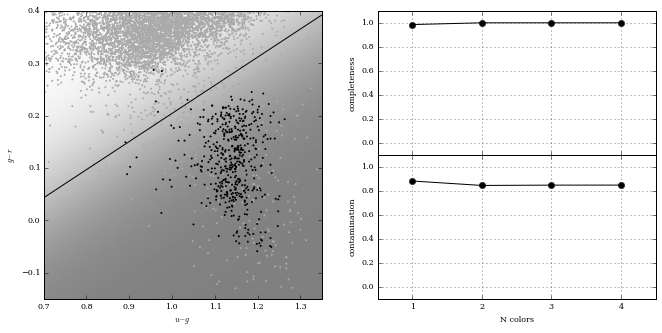

In [2]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

from sklearn.linear_model import LogisticRegression
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform Classification
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

for nc in Ncolors:
    clf = LogisticRegression(class_weight='auto')
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print "completeness", completeness
print "contamination", contamination

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

print clf.intercept_
print clf.raw_coef_

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 2)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)

ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

<h2>9.2 Support Vector Machines</h2>

The idea behind SVM is to find a hyperplane that maximizes the distance between the plane and the closest points of either class. This distance is referred to as the *margin* and data points on the margin are called *support vectors*. We begin with the assumption that the classes $y \in \{-1,1\}$ are linearly seperable.

To find the hyperplane that maximizes the margin one must maximize
$$\max_{\beta_0,\beta}(m)\quad \text{subject to} \quad \frac{1}{\|\beta\|}y_i(\beta_0 + \beta^T x_i) \geq m \quad \forall i.$$
For any $\beta_0$ and $\beta$ that satisfy the above inequality, any positive scaled multiple works as well, so we can set $\|\beta\|=1/m$ and rewrite the problem as minimizing
$$\frac{1}{2}\|\beta\|\quad \text{subject to} \quad y_i(\beta_0 + \beta^T x_i) \geq 1 \quad \forall i.$$

In realistic problems, the assumption that classes are linearly seperable must be relaxed. We add in *slack variables* $\xi_i$ and minimize
$$\frac{1}{2}\|\beta\|\quad \text{subject to} \quad y_i(\beta_0 + \beta^T x_i) \geq 1-\xi_i \quad \forall i.$$
We limit the slack by imposing constraints to effectively bound the number of misclassifications:
$$\xi_i \geq 0 \quad \text{and} \quad \displaystyle\sum_i \xi_i \leq C.$$

SVM optimization is equivalent to minimizing
$$\displaystyle\sum_{i=1}^N \max(0,1-y_ig(x_i)) + \lambda \|\beta\|^2,$$
where $\lambda$ is related to the tuning parameter C.

There is an equivalent way to write this problem using the inner products $\langle x_i,x_{i'}\rangle$ of $x_i$ and $x_{i'}$, which can be replaced with kernel functions $K(x_i,x_{i'})$ to make this method nonlinear [See Eq (9.36), (9.37), (9.38), and (9.42)].

@pickle_results: using precomputed results from 'SVM_rrlyrae.pkl'
completeness [ 0.99270073  1.          1.          1.        ]
contamination [ 0.89506173  0.8517316   0.85378869  0.85425532]


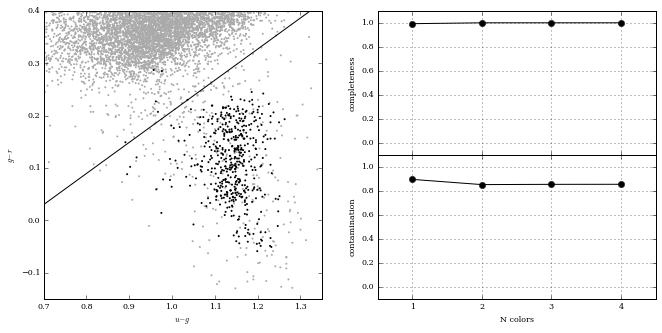

In [3]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from astroML.decorators import pickle_results
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # rearrange columns for better 1-color results

# SVM takes several minutes to run, and is order[N^2]
#  truncating the dataset can be useful for experimentation.
#X = X[::5]
#y = y[::5]

(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# Fit SVM
Ncolors = np.arange(1, X.shape[1] + 1)


@pickle_results('SVM_rrlyrae.pkl')
def compute_SVM(Ncolors):
    classifiers = []
    predictions = []

    for nc in Ncolors:
        # perform support vector classification
        clf = SVC(kernel='linear', class_weight='auto')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers.append(clf)
        predictions.append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_SVM(Ncolors)

completeness, contamination = completeness_contamination(predictions, y_test)

print "completeness", completeness
print "contamination", contamination

#------------------------------------------------------------
# compute the decision boundary
clf = classifiers[1]
w = clf.coef_[0]
a = -w[0] / w[1]
yy = np.linspace(-0.1, 0.4)
xx = a * yy - clf.intercept_[0] / w[1]

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
ax.plot(xx, yy, '-k')
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

ax.set_xlim(0.7, 1.35)
ax.set_ylim(-0.15, 0.4)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

@pickle_results: using precomputed results from 'kernelSVM_rrlyrae.pkl'
completeness [ 1.  1.  1.  1.]
contamination [ 0.90186246  0.8551797   0.85948718  0.8525296 ]


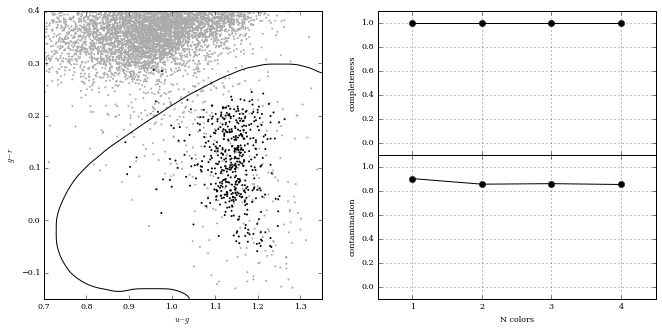

In [4]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn import metrics

from astroML.datasets import fetch_rrlyrae_mags
from astroML.decorators import pickle_results
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
X = X[:, [1, 0, 2, 3]]  # re-order the colors for better 1-color results

# SVM takes several minutes to run, and is order[N^2]
#  truncating the dataset can be useful for experimentation.
#X = X[::5]
#y = y[::5]

(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# Fit Kernel SVM
Ncolors = np.arange(1, X.shape[1] + 1)


@pickle_results('kernelSVM_rrlyrae.pkl')
def compute_SVM(Ncolors):
    classifiers = []
    predictions = []

    for nc in Ncolors:
        # perform support vector classification
        clf = SVC(kernel='rbf', gamma=20.0, class_weight='auto')
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers.append(clf)
        predictions.append(y_pred)

    return classifiers, predictions

classifiers, predictions = compute_SVM(Ncolors)

completeness, contamination = completeness_contamination(predictions, y_test)

print "completeness", completeness
print "contamination", contamination

#------------------------------------------------------------
# compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101),
                     np.linspace(ylim[0], ylim[1], 101))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

# smooth the boundary
from scipy.ndimage import gaussian_filter
Z = gaussian_filter(Z, 2)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

<h2>9.7 Decision Trees</h2>

Decision trees set up a heirarchical set of decision boundaries to classify data. Each node splits the data points it includes into two subsets, and this branching continues until predetermined stopping criteria are met. Branching decision boundaries are often based on one feature (axis aligned). Terminal (or leaf) nodes record the fraction of points they contain of each class, with the largest deciding which class is associated with that node.

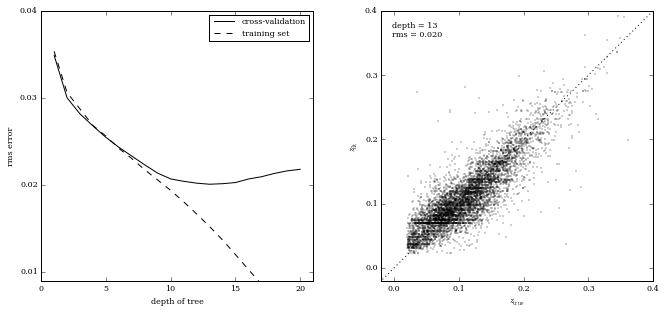

In [5]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from astroML.datasets import fetch_sdss_specgals

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Fetch data and prepare it for the computation
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 separate points
mag_test = mag[1::100]
z_test = z[1::100]

#------------------------------------------------------------
# Compute the cross-validation scores for several tree depths
depth = np.arange(1, 21)
rms_test = np.zeros(len(depth))
rms_train = np.zeros(len(depth))
i_best = 0
z_fit_best = None

for i, d in enumerate(depth):
    clf = DecisionTreeRegressor(max_depth=d, random_state=0)
    clf.fit(mag_train, z_train)

    z_fit_train = clf.predict(mag_train)
    z_fit = clf.predict(mag_test)
    rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
    rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

    if rms_test[i] <= rms_test[i_best]:
        i_best = i
        z_fit_best = z_fit

best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# first panel: cross-validation
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax.set_xlim(0, 21)
ax.set_ylim(0.009,  0.04)
ax.legend(loc=1)

# second panel: best-fit results
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.04, 0.96, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

<h3>9.7.1 Defining the Split Criteria</h3>

We can consider a simple split criteria based on the entropy of the data defined (in $\S$5.2.2) as
$$E(x)=-\displaystyle\sum_i p_i(x)\ln(p_i(x)).$$
Here $p_i$ is the probability of class $i$ given the training data. WE can define the reduction of entropy due to branching as the information gain (also known as Kullback-Leibler divergence). With a binary split where $i=0$ for points below the decision boundary and $i=1$ for those above it, the information gain is
$$IG(x|x_i)=E(x)-\displaystyle\sum_{i=0}^1\frac{N_i}{N}E(x_i),$$
where you have $N_i$ points $x_i$ in the $i$th class, ans $E(x_i)$ is the entropy associated with that class.

Other commonly used loss functions are the Gini coefficient ($\S4.7.2$) and the misclassification error. The Gini coefficient for a $k$-class sample is
$$G=\displaystyle\sum_i^k p_i(1-p_i).$$
Here $p_i$ is the probability of finding a point with class $i$ within a data set. The misclassification error is
$$MC=1-\displaystyle\max_i(p_i).$$

<h3>9.7.2 Building the Tree</h3>

Where do you stop? There are several ways to find stopping criteria so as to capture trends while avoiding capturing the noise of the training set. Common options include the following:
    - If a node contains only one class of object
    - If splitting does not supply information gain or reduce misclassifications
    - If a node contains a predefined number of points
Overall tree depth can be determined by using a cross validation set to determine when the complexity of the model starts overfitting data.

Another option is pruning: method where the tree grows until nodes contain a small predefined number of points and then cross validation is used to determine where to remove branching nodes in the tree.

<h3>9.7.3 Bagging and Random Forests</h3>

Ensemble learning (the idea of taking outputs of multiple models and combining them) gives us two methods of improving our classification. In bagging, the predictive results of a series of bootstrap samples (see $\S4.5$) are averaged. For a sample of $N$ points in a training set, bagging generates $K$ bootstrap samples of equal size to estimate $f_i(x)$. The final bagging estimator is
$$f(x)=\frac{1}{K} \displaystyle\sum_i^K f_i(x).$$

Random forests generate a decision tree for each in a series of bootstrap samples. To generate a forest we need to define the number of trees $n$ to use and the number of features $m$ to decide on a boundary at each node. Features on which to split are randomly decided upon at each node. Random forests address both the overfitting of deep trees and the nonlinear boundaries in data sets that single decision trees do not.

@pickle_results: using precomputed results from 'photoz_forest.pkl'


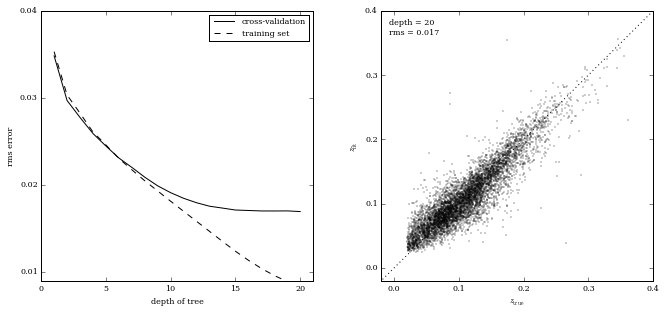

In [6]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from astroML.datasets import fetch_sdss_specgals
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Fetch and prepare the data
data = fetch_sdss_specgals()

# put magnitudes in a matrix
mag = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
z = data['z']

# train on ~60,000 points
mag_train = mag[::10]
z_train = z[::10]

# test on ~6,000 distinct points
mag_test = mag[1::100]
z_test = z[1::100]


#------------------------------------------------------------
# Compute the results
#  This is a long computation, so we'll save the results to a pickle.
@pickle_results('photoz_forest.pkl')
def compute_photoz_forest(depth):
    rms_test = np.zeros(len(depth))
    rms_train = np.zeros(len(depth))
    i_best = 0
    z_fit_best = None

    for i, d in enumerate(depth):
        clf = RandomForestRegressor(n_estimators=10,
                                    max_depth=d, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt((z_fit_train - z_train) ** 2))
        rms_test[i] = np.mean(np.sqrt((z_fit - z_test) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best


depth = np.arange(1, 21)
rms_test, rms_train, i_best, z_fit_best = compute_photoz_forest(depth)
best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, '-k', label='cross-validation')
ax.plot(depth, rms_train, '--k', label='training set')
ax.legend(loc=1)

ax.set_xlabel('depth of tree')
ax.set_ylabel('rms error')

ax.set_xlim(0, 21)
ax.set_ylim(0.009,  0.04)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

# right panel: plot best fit
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax.text(0.03, 0.97, "depth = %i\nrms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$z_{\rm true}$')
ax.set_ylabel(r'$z_{\rm fit}$')

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

<h3>9.7.4 Boosting Classification</h3>

Boosting is another ensemble method that iterates over a sample, changing the weights of data points after each iteration in an attempt to fix errors in the previous attempt. If we have a "weak" classifier $h(x)$ we can make a "strong" classifier $f(x)$, such that
$$f(x)=\displaystyle\sum_m^K \theta_mh_m(x),$$
where $m$ indicates the iteration and $\theta_m$ is the weight of that iteration of the classifier.
For a data set of $N$ points with known classifications $y$, we can assign a weight $w_m(x)$ to each point (With the initial weight being uniform $1/N$). After application of the weak classifier, we estimate the classification error as
$$e_m = \displaystyle\sum_{i=1}^N w_m(x_i) \times \begin{cases} 1 & h_m(x_i) \neq y_i, \\ 0 & \text{otherwise.}\end{cases}$$
We then define the weight of that iteration as
$$\theta_m = \frac{1}{2}\log{\left(\frac{1-e_m}{e_m}\right)},$$
and update the weight of each point:
$$w_{m+1}(x_i) = w_m(x_i) \times \begin{cases} e^{-\theta_m} & h_m(x_i) = y_i \\ e^{\theta_m} & h_m(x_i) \neq y_i\end{cases}
= \frac{w_m(x_i)e^{-\theta_m y_i h_m(x_i)}}{\sum_{i=1}^N w_m(x_i) e^{-\theta_m y_i h_m(x_i)}}.$$

Since each iteration depends on the previous iteration, parallelization is not possible here. This can lead to comutation time problems with large data sets. An alternative to adaptive boosting is gradient boosting, which may scale better to larger data.

<h2>9.8 Evaluating Classifiers: ROC Curves</h2>

Receiver operating characteristic (ROC) curves can be useful for visualizing how well classification methods work. They also conveniently show the trade offs between completeness and efficiency. The graphs can also be true positives vs, false positives, though this may not be the most useful when your data includes a large number of background data points.

GaussianNB
LDA
QDA
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


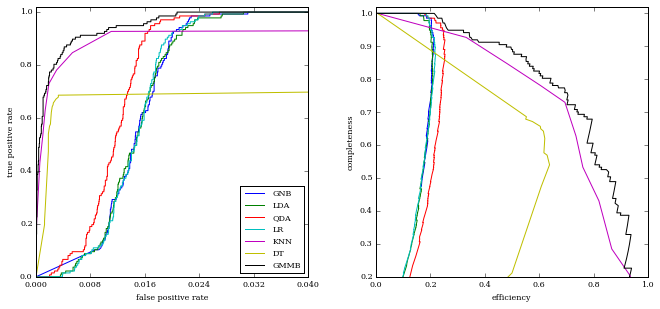

In [7]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes

from sklearn.metrics import precision_recall_curve, roc_curve

from astroML.utils import split_samples, completeness_contamination
from astroML.datasets import fetch_rrlyrae_combined

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#----------------------------------------------------------------------
# get data and split into training & testing sets
X, y = fetch_rrlyrae_combined()
y = y.astype(int)
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)


#------------------------------------------------------------
# Fit all the models to the training data
def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        print classifier.__name__
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        y_probs = clf.predict_proba(X_test)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs

names, probs = compute_models((GaussianNB, {}),
                              (LDA, {}),
                              (QDA, {}),
                              (LogisticRegression,
                               dict(class_weight='auto')),
                              (KNeighborsClassifier,
                               dict(n_neighbors=10)),
                              (DecisionTreeClassifier,
                               dict(random_state=0, max_depth=12,
                                    criterion='entropy')),
                              (GMMBayes, dict(n_components=3, min_covar=1E-5,
                                              covariance_type='full')))

#------------------------------------------------------------
# Plot ROC curves and completeness/efficiency
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)


# ax2 will show roc curves
ax1 = plt.subplot(121)

# ax1 will show completeness/efficiency
ax2 = plt.subplot(122)

labels = dict(GaussianNB='GNB',
              LDA='LDA',
              QDA='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

thresholds = np.linspace(0, 1, 1001)[:-1]

# iterate through and show results
for name, y_prob in zip(names, probs):
    fpr, tpr, thresh = roc_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    ax1.plot(fpr, tpr, label=labels[name])

    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
    ax2.plot(1 - cont, comp, label=labels[name])

ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.legend(loc=4)

ax2.set_xlabel('efficiency')
ax2.set_ylabel('completeness')
ax2.set_xlim(0, 1.0)
ax2.set_ylim(0.2, 1.02)

plt.show()

<h2>9.9 Which Classifier Should I Use?</h2>

Here's how the different methods perform in different areas.

<h4>Accuracy:</h4>
In general, it can't be stated what will be most accurate, but there are a few rules of thumb.
    - More parameters -> potentially more accurate
    - Ensemble methods are often more accurate
    - Nonparametric are usually more accurate for large data sets
    - Parametric can be more accurate for small data sets, or high dimension sets

<h4>Interpretability:</h4>
Parametric models are often the methods that will be interpretable, though some parametric models (KNN, Decision trees) are still interpretable.

<h4>Scalability:</h4>
Naive Bayes (and variants) is by far the easiest to compute, and logistic regression and linear support vector machines are next on the list. Scalability usually means that the method gives a simpler model for classification.

<h4>Simplicity:</h4>
Naive Beyes takes the cake here. Other simple methods include logistic regression, decision trees, and K nearest neighbors.

*Table 9.1 in the book has a nice comparison of the classification methods*.